In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

In [120]:
# 1. Load data
df = pd.read_csv('Telco-Customer-Churn.csv')

In [122]:
# 2. Clean data
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')  # Convert invalid strings to NaN
df = df.dropna(subset=['TotalCharges'])  # Drop rows where TotalCharges couldn't be converted
df['TotalCharges'] = df['TotalCharges'].astype(float)  # Optional: enforce float type

In [124]:
df.to_csv("cleaned_telco.csv", index=False)

In [126]:
# 3. Select features for clustering
features = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)

In [163]:
from sklearn.preprocessing import StandardScaler

features = df[['tenure', 'MonthlyCharges', 'TotalCharges']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

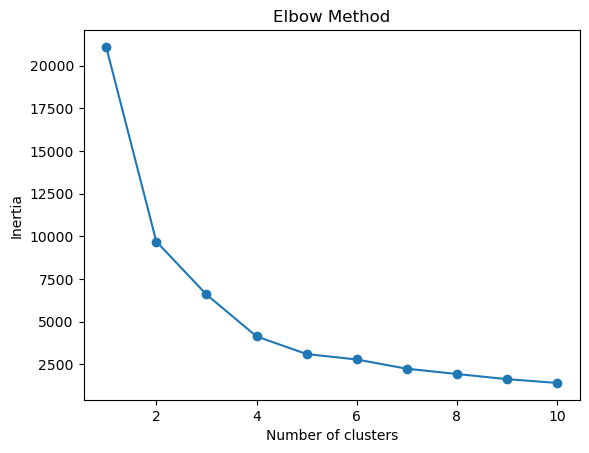

In [130]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)
    
    import os
os.makedirs("images_segmentation", exist_ok=True)

plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig("images_segmentation/elbow_plot.png", dpi=300, bbox_inches='tight')
plt.show()

In [131]:
# 4. Elbow method for optimal k
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

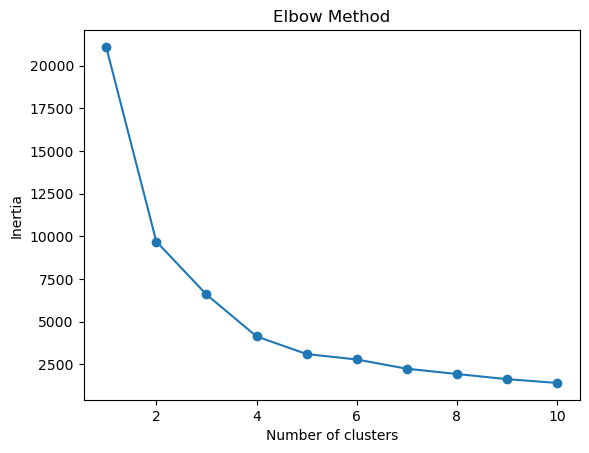

In [134]:
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [136]:
# 5. Fit K-Means
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(scaled_df)

KMeans(n_clusters=4, random_state=42)

In [138]:
# Fit K-Means and assign cluster labels
df['Cluster'] = kmeans.fit_predict(scaled_features)

In [140]:
# 6. PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

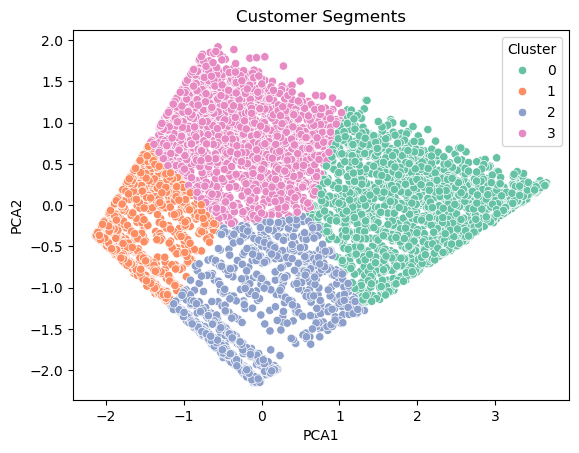

In [142]:
# 7. Visualize clusters
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2')
plt.title('Customer Segments')
plt.savefig("images_segmentation/customer_segments.png", dpi=300, bbox_inches='tight')
plt.show()

In [143]:
import joblib

# Suppose `kmeans` is your trained model
joblib.dump(kmeans, "churn_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [145]:
print("✅ Model and scaler saved.")

✅ Model and scaler saved.


              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1549
           1       0.62      0.48      0.54       561

    accuracy                           0.78      2110
   macro avg       0.72      0.69      0.70      2110
weighted avg       0.77      0.78      0.77      2110



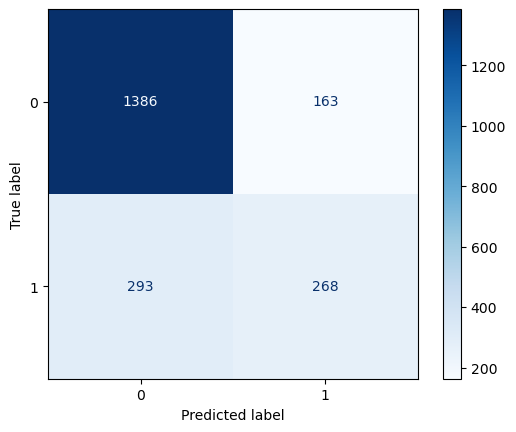

In [148]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import shap

# 1️⃣ Prepare data for churn prediction
X = df.drop(['customerID','Churn','Cluster','PCA1','PCA2'], axis=1, errors='ignore')
X = pd.get_dummies(X, drop_first=True)
y = df['Churn'].map({'Yes':1,'No':0})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# 2️⃣ Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# 3️⃣ Predictions + Metrics
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

# 4️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
os.makedirs("images_segmentation", exist_ok=True)
plt.savefig("images_segmentation/confusion_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


<Figure size 640x480 with 0 Axes>

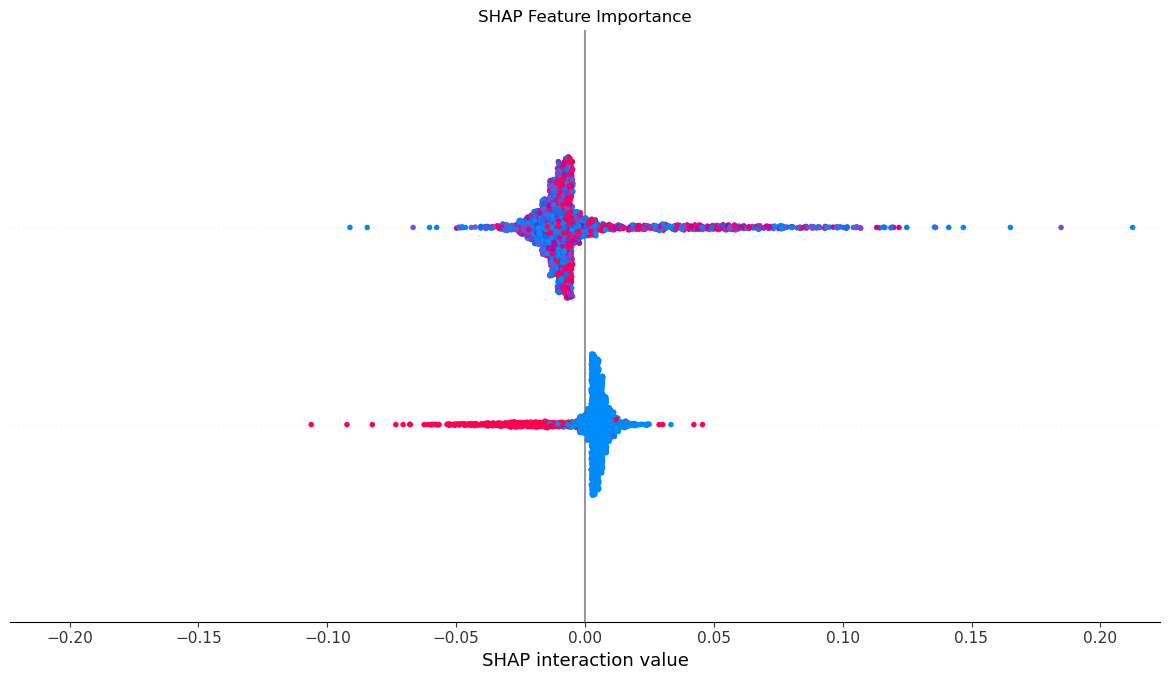

In [149]:
# Align test data with model features
X_test = X_test[rf_model.feature_names_in_]

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values_to_plot = shap_values[1]
else:
    shap_values_to_plot = shap_values

shap.summary_plot(shap_values_to_plot, X_test, plot_type="bar", show=False)

plt.title("SHAP Feature Importance")
os.makedirs("images_segmentation", exist_ok=True)
plt.savefig("images_segmentation/shap_bar_rf.png", dpi=300, bbox_inches='tight')
plt.show()

In [223]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_tirain)
X_test_scaled = scaler.transform(X_test)

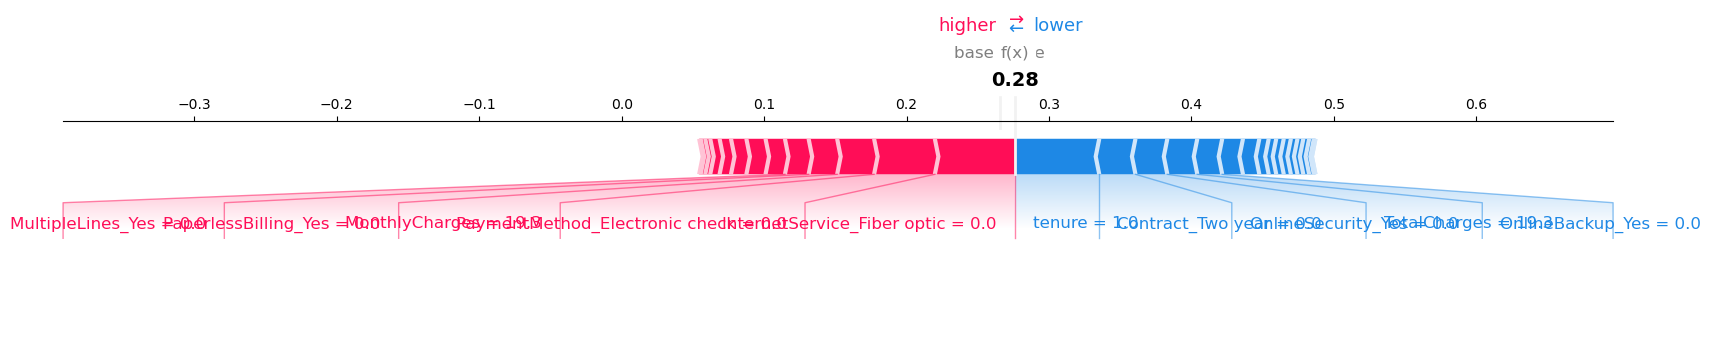

<Figure size 640x480 with 0 Axes>

In [241]:
# Transpose SHAP values to (samples, features)
shap_values_corrected = shap_values[1].T  # shape: (1407, 19)

# Pick a sample to explain
sample_idx = 0
sample = X_test.iloc[sample_idx]
sample_shap = shap_values_corrected[sample_idx]  # shape: (19,)

# Now create the force plot
shap.initjs()
shap.plots.force(
    explainer.expected_value[1],  # For class 1
    sample_shap,
    sample,
    matplotlib=True
)
plt.savefig("images_segmentation/shap_force_rf.png")